Import libraries and modules used for analysis

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from sklearn.model_selection import train_test_split
from sklearn import cluster, datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_rel, norm

Retrieve air quality measures from EPA

In [91]:
Air_Qual = pd.read_csv('Air_Qual.csv')

Death_2012_1 = pd.read_csv('Underlying Cause of Death, 2012.txt',sep='\t', usecols = ["ICD Sub-Chapter","ICD Sub-Chapter Code","State","State Code","County","County Code","2013 Urbanization","2013 Urbanization Code","Five-Year Age Groups","Five-Year Age Groups Code","Deaths","Population","Crude Rate","% of Total Deaths"])
Death_2012_1['Year'] = 2012
Death_2013_1 = pd.read_csv('Underlying Cause of Death, 2013.txt',sep='\t', usecols = ["ICD Sub-Chapter","ICD Sub-Chapter Code","State","State Code","County","County Code","2013 Urbanization","2013 Urbanization Code","Five-Year Age Groups","Five-Year Age Groups Code","Deaths","Population","Crude Rate","% of Total Deaths"])
Death_2013_1['Year'] = 2013
Death_2014_1 = pd.read_csv('Underlying Cause of Death, 2014.txt',sep='\t', usecols = ["ICD Sub-Chapter","ICD Sub-Chapter Code","State","State Code","County","County Code","2013 Urbanization","2013 Urbanization Code","Five-Year Age Groups","Five-Year Age Groups Code","Deaths","Population","Crude Rate","% of Total Deaths"])
Death_2014_1['Year'] = 2014
Death_2015_1 = pd.read_csv('Underlying Cause of Death, 2015.txt',sep='\t', usecols = ["ICD Sub-Chapter","ICD Sub-Chapter Code","State","State Code","County","County Code","2013 Urbanization","2013 Urbanization Code","Five-Year Age Groups","Five-Year Age Groups Code","Deaths","Population","Crude Rate","% of Total Deaths"])
Death_2015_1['Year'] = 2015

Retrieve data on diabetes

In [92]:
Diabetes = pd.read_csv('Diabetes.csv',sep=',', usecols = ['State','County','Prevalence, 1999, Both Sexes',
'Prevalence, 2000, Both Sexes','Prevalence, 2001, Both Sexes','Prevalence, 2002, Both Sexes',
'Prevalence, 2003, Both Sexes','Prevalence, 2004, Both Sexes','Prevalence, 2005, Both Sexes', 
'Prevalence, 2006, Both Sexes','Prevalence, 2007, Both Sexes','Prevalence, 2008, Both Sexes',
'Prevalence, 2009, Both Sexes','Prevalence, 2010, Both Sexes','Prevalence, 2011, Both Sexes',
'Prevalence, 2012, Both Sexes'])  

pandas_dict = {}
Year_list = [(2000,'2000'),(2001,'2001'),(2002,'2002'),(2003,'2003'),(2004,'2004'),
             (2005,'2005'),(2006,'2006'),(2007,'2007'),(2008,'2008'),(2009,'2009'),
             (2010,'2010'),(2011,'2011'),(2012,'2012')]
for k,v in Year_list:
    pandas_dict[k] = Diabetes[['State','County','Prevalence, %r, Both Sexes' %k]]

Diabetes_list = []
Diabetes = pd.DataFrame()
for k,v in pandas_dict.items():
    v['Year'] = k
    v.columns.values[2] = 'Prevalence of Diabetes'
    Diabetes_list.append(v)
Diabetes_Concat = pd.concat(Diabetes_list)
Diabetes_Concat['County'] = Diabetes_Concat['County'].apply(lambda x: x.split()[0])

Retrieve data on poverty

In [93]:
import glob
import errno
import os
path = '/Users/jitsen/Documents/metis/metisgh/CDC/Poverty'
content = []
for filename in glob.glob(os.path.join(path, '*.csv')):
    content.append(filename)
    
Poverty = pd.read_csv(content[0],usecols = ['Year','State / County Name','All Ages in Poverty Percent',
                                           'Median Household Income in Dollars','County ID'])
for i in content[1:]:
    Poverty = pd.concat([Poverty, pd.read_csv(i,usecols = ['Year','State / County Name','All Ages in Poverty Percent',
                                                          'Median Household Income in Dollars','County ID'])])

Change coding scheme for states in order to merge with other tables

In [94]:
Poverty['County'] = Poverty['State / County Name'].apply(lambda x : x.split()[0])
Poverty['State'] = Poverty['State / County Name'].apply(lambda x : x.split()[-1][1:3])
states = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California','CO': 'Colorado',
        'CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','GU': 'Guam',
        'HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky',
        'LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota',
        'MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina',
        'ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada',
        'NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island',
        'SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia',
        'VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'}

Poverty['State'] = Poverty['State'].map(states)

Poverty['Median_Income'] = Poverty['Median Household Income in Dollars'].apply(lambda x : re.sub('[^0-9]','',str(x)))
Poverty['Median_Income'] = pd.to_numeric(Poverty['Median_Income'], errors='coerce')

Merge Tables on Diabetes and Poverty

In [95]:
Diabetes_Poverty= pd.merge(Diabetes_Concat, Poverty,left_on = ['County','Year','State'],
                  right_on = ['County','Year','State'])

Checking if intergerity if tables was preserved

In [96]:
Diabetes_Poverty['Year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012])

Use air quality measure pertaining to P2.5 density

In [97]:
Air_Qual_2_5 = Air_Qual[Air_Qual['MeasureId']==296]

Merge tables containing information on diabetes, poverty and air quality

In [98]:
Diabetes_Poverty_Air_Qual_2_5 = pd.merge(Diabetes_Poverty,Air_Qual_2_5,
                left_on = ['County','Year','State'], 
                                right_on = ['CountyName','ReportYear','StateName'])

Penalize years with poor air quality by adding a squared term to the merged table

In [99]:
Diabetes_Poverty_Air_Qual_2_5['Value_sq'] = Diabetes_Poverty_Air_Qual_2_5['Value'].apply(
lambda x: x**2 )

Get moving average datasets for four year comparison

In [100]:
DPA_2008 = Diabetes_Poverty_Air_Qual_2_5[(Diabetes_Poverty_Air_Qual_2_5['ReportYear'] >= 2001)&
                                        (Diabetes_Poverty_Air_Qual_2_5['ReportYear'] <= 2008)]
DPA_2009 = Diabetes_Poverty_Air_Qual_2_5[(Diabetes_Poverty_Air_Qual_2_5['ReportYear'] >= 2002)&
                                        (Diabetes_Poverty_Air_Qual_2_5['ReportYear'] <= 2009)]
DPA_2010 = Diabetes_Poverty_Air_Qual_2_5[(Diabetes_Poverty_Air_Qual_2_5['ReportYear'] >= 2003)&
                                        (Diabetes_Poverty_Air_Qual_2_5['ReportYear'] <= 2010)]
DPA_2011 = Diabetes_Poverty_Air_Qual_2_5[(Diabetes_Poverty_Air_Qual_2_5['ReportYear'] >= 2004)&
                                        (Diabetes_Poverty_Air_Qual_2_5['ReportYear'] <= 2011)]


Prior to merging, reset index and set comparison years for moving average dataset as 2012-2015

In [101]:
DPA_2008_mean = DPA_2008[['State', 'County', 'Prevalence of Diabetes', 'Year','State / County Name',
'Median_Income','All Ages in Poverty Percent','Value','Value_sq','CountyFips']].groupby(['State','County']).mean()
DPA_2008_mean = DPA_2008_mean.reset_index()
DPA_2008_mean['Comp_Year'] = 2012

DPA_2009_mean = DPA_2009[['State', 'County', 'Prevalence of Diabetes', 'Year','State / County Name',
'Median_Income','All Ages in Poverty Percent','Value','Value_sq','CountyFips']].groupby(['State','County']).mean()
DPA_2009_mean = DPA_2009_mean.reset_index()
DPA_2009_mean['Comp_Year'] = 2013

DPA_2010_mean = DPA_2010[['State', 'County', 'Prevalence of Diabetes', 'Year','State / County Name',
'Median_Income','All Ages in Poverty Percent','Value','Value_sq','CountyFips']].groupby(['State','County']).mean()
DPA_2010_mean = DPA_2010_mean.reset_index()
DPA_2010_mean['Comp_Year'] = 2014

DPA_2011_mean = DPA_2011[['State', 'County', 'Prevalence of Diabetes', 'Year','State / County Name',
'Median_Income','All Ages in Poverty Percent','Value','Value_sq','CountyFips']].groupby(['State','County']).mean()
DPA_2011_mean = DPA_2011_mean.reset_index()
DPA_2011_mean['Comp_Year'] = 2015


Pick data tables for death counts using only years 2012 to 2015

In [102]:
Death_concat = pd.concat([Death_2012_1,Death_2013_1,
               Death_2014_1,Death_2015_1])

Death_new = Death_concat[['State','County','2013 Urbanization','2013 Urbanization Code',
'Five-Year Age Groups','Deaths','Population','Year','ICD Sub-Chapter']]
Death_new['County'] = Death_new.County.str.split().str[0]
cols = ['State','County','2013 Urbanization','2013 Urbanization Code',
'Five-Year Age Groups','Deaths','Population','Year','ICD Sub-Chapter']
Death_new = Death_new.loc[:, cols].dropna()

DPA_concat = pd.concat([DPA_2008_mean,DPA_2009_mean,DPA_2010_mean,DPA_2011_mean])


/Users/jitsen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Merge moving average dataset and data on death, using years 2012-2015 as a link

In [103]:
Death_DPA_merge = pd.merge(DPA_concat, Death_new,left_on = ['State','County','Comp_Year'],
                          right_on = ['State','County','Year'])

Add Geo-Coordinates as a feature

In [104]:
Death_DPA_merge = Death_DPA_merge[Death_DPA_merge['Population'] != 'Not Applicable']
Death_DPA_merge['Population'] = Death_DPA_merge['Population'].astype('int')
Death_DPA_merge['prop_death'] = Death_DPA_merge['Deaths']/Death_DPA_merge['Population']
Death_DPA_merge['Five-Year Age Groups'] = Death_DPA_merge['Five-Year Age Groups'].apply(
lambda x : (int(x[3:5])+int(x[0:2]))/2)
Death_DPA_merge
Death_DPA_merge_COPD = Death_DPA_merge[Death_DPA_merge['ICD Sub-Chapter'] == 'Chronic lower respiratory diseases']

In [105]:
Geo_coord = pd.read_csv('zip_codes_states.csv')
Geo_coord['state'] = Geo_coord['state'].map(states)
Geo_coord_mean = Geo_coord.groupby(['state','county',]).mean()
Geo_coord_mean = Geo_coord_mean.reset_index()
Death_m_concat_geo = pd.merge(Death_DPA_merge_COPD,Geo_coord_mean, left_on = ['State','County'],
                              right_on = ['state','county'])
Death_m_concat_geo.head()

,State,County,Prevalence of Diabetes,Year_x,Median_Income,All Ages in Poverty Percent,Value,Value_sq,CountyFips,Comp_Year,...,Deaths,Population,Year_y,ICD Sub-Chapter,prop_death,state,county,zip_code,latitude,longitude
0,Alabama,Baldwin,8.02125,2004.5,44353.625,10.5625,11.530307,133.452176,1003.0,2012,...,13.0,6071,2012,Chronic lower respiratory diseases,0.002141,Alabama,Baldwin,36550.307692,30.587202,-87.719056
1,Alabama,Baldwin,8.02125,2004.5,44353.625,10.5625,11.530307,133.452176,1003.0,2012,...,17.0,4114,2012,Chronic lower respiratory diseases,0.004132,Alabama,Baldwin,36550.307692,30.587202,-87.719056
2,Alabama,Baldwin,8.28875,2005.5,45382.500,10.8375,11.197984,126.490542,1003.0,2013,...,17.0,11961,2013,Chronic lower respiratory diseases,0.001421,Alabama,Baldwin,36550.307692,30.587202,-87.719056
3,Alabama,Baldwin,8.28875,2005.5,45382.500,10.8375,11.197984,126.490542,1003.0,2013,...,18.0,9160,2013,Chronic lower respiratory diseases,0.001965,Alabama,Baldwin,36550.307692,30.587202,-87.719056
4,Alabama,Baldwin,8.28875,2005.5,45382.500,10.8375,11.197984,126.490542,1003.0,2013,...,14.0,6465,2013,Chronic lower respiratory diseases,0.002166,Alabama,Baldwin,36550.307692,30.587202,-87.719056


Find median value for p2.5 density counts

In [106]:
Death_m_concat_geo['Value'].median()

12.147984093360275

Plot value counts to analyze distribution

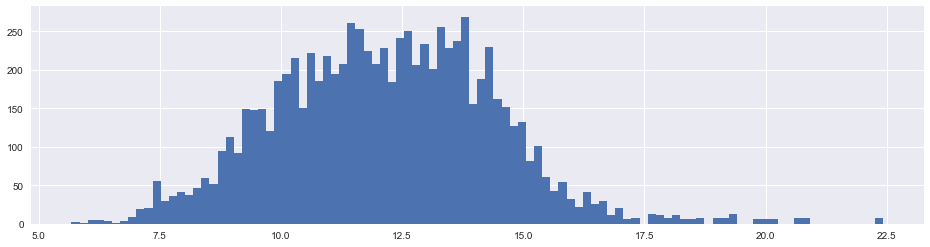

In [107]:
plt.figure(figsize = (16,4))
plt.hist(Death_m_concat_geo['Value'], bins = 100)
plt.show()

Split data into high density counties and low density counties based on median P2.5 density

In [108]:
Death_m_concat_geo['Pollution'] = Death_m_concat_geo['Value'].apply(lambda x: 'high' if x > 12.0489 else 'low' if x < 12.0489  else 'neutral')

Log transform data and get probabilities of counties having 'high' density

In [109]:
X_log = Death_m_concat_geo[['Comp_Year','Prevalence of Diabetes',
       'All Ages in Poverty Percent','2013 Urbanization Code',
       'latitude', 'longitude','Population','Five-Year Age Groups']]

y_log = Death_m_concat_geo['Pollution']

scaler = MinMaxScaler(feature_range=(0, 1))
X_log_t = scaler.fit_transform(X_log)

Lr = LogisticRegression(penalty = 'l1', dual=False, tol=0.0001,fit_intercept=True, intercept_scaling=1)
Lr.fit(X_log_t, y_log)
y_pred = pd.DataFrame(Lr.predict_proba(X_log_t))
Death_m_concat_geo['High_Proba'] = y_pred[0].apply(lambda x : np.log(x))
Death_m_concat_geo['Low_Proba'] = y_pred[1].apply(lambda x : np.log(x))

Make sure there is significant overlap between two groups to do pairwise tests

No handles with labels found to put in legend.


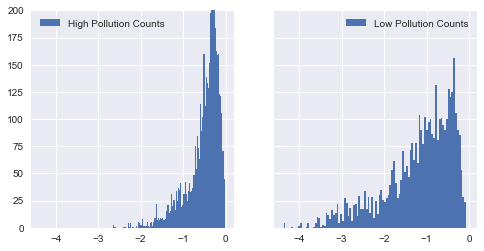

In [110]:
fig, ax = plt.subplots(1,2, figsize = (8,4), sharey = True, sharex = True);
ax[0].hist(Death_m_concat_geo['High_Proba'][Death_m_concat_geo['Pollution']=='high'],bins=100, label= 'High Pollution Counts');
plt.legend();
ax[1].hist(Death_m_concat_geo['High_Proba'][Death_m_concat_geo['Pollution']=='low'],bins=100, label ='Low Pollution Counts');
ax[0].legend();
ax[1].legend();
plt.ylim(0,200)
plt.show();

In [111]:
Death_m_concat_geo['High_Proba'][Death_m_concat_geo['Pollution']=='low'].shape

(4023,)

Split data frame into high density and low density groups

In [112]:
Death_m_concat_geo2 = Death_m_concat_geo[Death_m_concat_geo['High_Proba']>=-1.8]
low = Death_m_concat_geo2[['State','County','Comp_Year','Prevalence of Diabetes',
       'All Ages in Poverty Percent','Value', 'Value_sq','2013 Urbanization Code','Deaths',
       'latitude', 'longitude','prop_death','Population','Five-Year Age Groups','Pollution','High_Proba']][Death_m_concat_geo2['Pollution']=='low']
high = Death_m_concat_geo2[['State','County','Comp_Year','Prevalence of Diabetes',
       'All Ages in Poverty Percent','Value','Value_sq','2013 Urbanization Code','Deaths',
       'latitude', 'longitude','prop_death','Population','Five-Year Age Groups','Pollution','High_Proba']][Death_m_concat_geo2['Pollution']=='high']

low.columns = [i+"_low" for i in low.columns]
high.columns = [i+"_high" for i in high.columns]

Merge dataframes in order to do pairwise matches between the two groups on 'predict_proba' values

In [113]:
low_high_merge = pd.merge(high,low, how = 'outer', left_on = ['Comp_Year_high','Five-Year Age Groups_high'],
                         right_on = ['Comp_Year_low','Five-Year Age Groups_low'] )

In [114]:
low_high_merge.shape

(672497, 32)

In [115]:
low_high_merge['Value_Diff'] = low_high_merge['Value_high']-low_high_merge['Value_low']
low_high_merge['Prob_Diff'] = low_high_merge['High_Proba_high']-low_high_merge['High_Proba_low']
low_high_merge['prop_death_diff'] = low_high_merge['prop_death_high']*1000-low_high_merge['prop_death_low']*1000

Set caliper width to .0005

In [116]:
low_high_merge_2 = low_high_merge[(low_high_merge['Prob_Diff'] <= .0005)&
                                 (low_high_merge['Prob_Diff'] >= -.0005)]

low_high_merge_2.shape

(486, 35)

Plot differences in deaths on pairwise matches

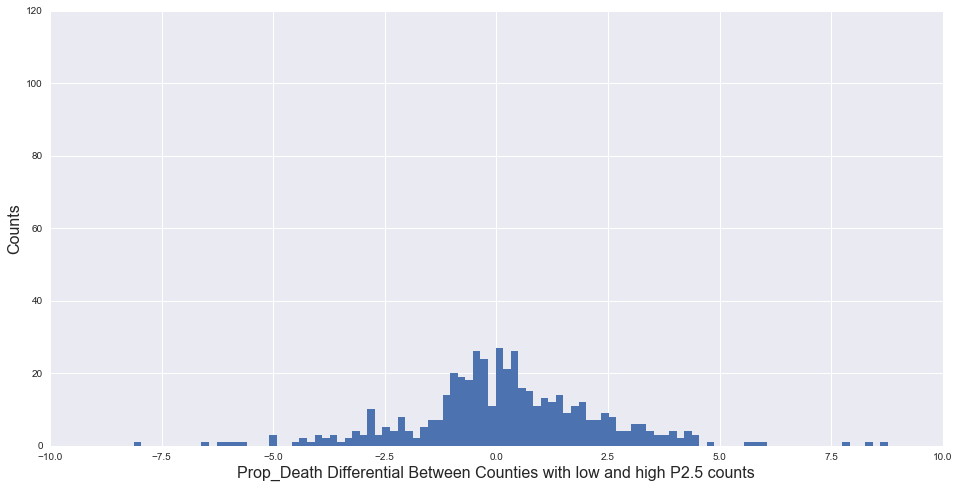

In [117]:
plt.figure(figsize = (16,8))
plt.hist(low_high_merge_2['prop_death_diff'], bins = 100)
plt.xlabel('Prop_Death Differential Between Counties with low and high P2.5 counts', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.xlim(-10,10)
plt.ylim(0,120)

plt.show()

Observe mean difference in deaths, along with mean deaths in both high density and low density groups

In [118]:
low_high_merge_2['prop_death_diff'].mean(),low_high_merge_2['prop_death_high'].mean()*1000,low_high_merge_2['prop_death_low'].mean()*1000

(0.20811629499793108, 3.3270289078862647, 3.118912612888329)

In [119]:
low_high_merge_2['prop_death_diff'].sem(), norm.ppf(.8),norm.ppf(.975)

z_score = low_high_merge_2['prop_death_diff'].mean()/(norm.ppf(.8)+norm.ppf(.975))

(2*low_high_merge_2['prop_death_diff'].var())/z_score**2

1604.4453564037824

Plot difference in paired means against P2.5 density. Linear relationship is not apparent

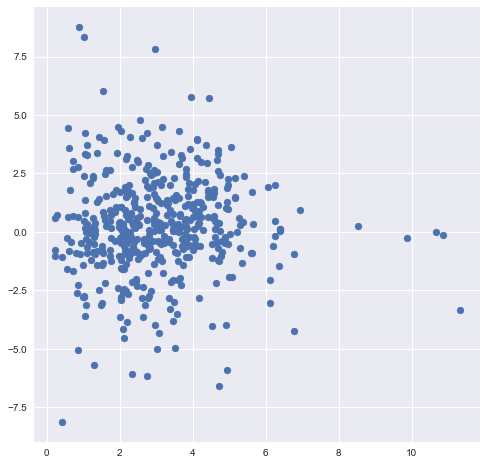

In [120]:
Death_Value_list = zip(low_high_merge_2['prop_death_diff'],low_high_merge_2['Value_Diff'])
Death_Value_list2 = sorted(Death_Value_list, key=lambda x: x[1])

plt.figure(figsize = (8,8))
plt.scatter([x[1] for x in Death_Value_list2],[x[0] for x in Death_Value_list2])
plt.show()

Run a T-Test on the mean difference between pairs from 'high' and 'low' particulate density groups

In [121]:
ttest_rel(low_high_merge_2['prop_death_high']*1000,low_high_merge_2['prop_death_low']*1000, axis=0, nan_policy='propagate')

Ttest_relResult(statistic=2.1805924518490558, pvalue=0.029693429502804833)

In [122]:
low_high_merge_2['prop_death_diff'].quantile(q=0.975),low_high_merge_2['prop_death_diff'].quantile(q=0.025)

(4.234392957011787, -4.138572548095642)

Run paired T-Test on all other features, to make sure they aren't statistically significant

In [123]:
ttest_rel(low_high_merge_2['All Ages in Poverty Percent_high'],low_high_merge_2['All Ages in Poverty Percent_low'], axis=0, nan_policy='propagate')

Ttest_relResult(statistic=-0.34819329313163017, pvalue=0.72784610419932094)

In [124]:
ttest_rel(low_high_merge_2['Prevalence of Diabetes_high'],low_high_merge_2['Prevalence of Diabetes_low'], axis=0, nan_policy='propagate')

Ttest_relResult(statistic=1.5164382816697632, pvalue=0.13006004887462835)

In [125]:
ttest_rel(low_high_merge_2['latitude_high'],low_high_merge_2['latitude_low'], axis=0, nan_policy='propagate')


Ttest_relResult(statistic=-1.7531999212920373, pvalue=0.080199431536635599)

In [126]:
ttest_rel(low_high_merge_2['longitude_high'],low_high_merge_2['longitude_low'], axis=0, nan_policy='propagate')


Ttest_relResult(statistic=-1.5879875979619018, pvalue=0.11294081592343798)

In [127]:
ttest_rel(low_high_merge_2['Five-Year Age Groups_high'],low_high_merge_2['Five-Year Age Groups_low'], axis=0, nan_policy='propagate')

/Users/jitsen/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3833: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


Ttest_relResult(statistic=nan, pvalue=nan)

In [128]:
ttest_rel(low_high_merge_2['2013 Urbanization Code_high'],low_high_merge_2['2013 Urbanization Code_low'],
         axis=0, nan_policy='propagate')

Ttest_relResult(statistic=1.5789010789312918, pvalue=0.11501070172712624)

In [129]:
ttest_rel(low_high_merge_2['Population_high'],low_high_merge_2['Population_low'],
         axis=0, nan_policy='propagate')

Ttest_relResult(statistic=-0.85491694326283885, pvalue=0.39301923624477486)

Conclustion: Death counts per thousand seems to be the only statistically significant metric when running a paired T-Test between pairs of counties from the 'high' and 'low' particulate matter density groups. Theref